# Load data and understand it

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('/kaggle/input/diabetes-dataset/diabetes.csv')

In [2]:
df.shape

(768, 9)

In [3]:
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


* I can see a bunch of outliers. We need to be cautious.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* No null values. That is good news. All features are numeric. no encoding needed.

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
print(df['Outcome'].value_counts(normalize=True) * 100)

Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


* Outcome 0 = 65.1%, Outcome 1 = 34.9%→ Not perfectly balanced but not extremely skewed.→ Still something to keep in mind — evaluation metrics like F1-score and ROC-AUC will be more informative than just accuracy.
* Glucose, BloodPressure, SkinThickness, Insulin, BMI have unrealistic minimum values of 0.→ These are likely placeholders for missing data and need imputation.
* Example: Blood Pressure = 0 mmHg is biologically impossible for a living patient.
* Glucose goes up to 199 — okay for diabetic cases.
* Insulin has extreme outliers (max = 846).
* Age goes up to 81 — suggests adult patient dataset.
* We have lots of zeros(I think they used it as nan XD).

# Zero detection

In [7]:
# Columns where zero is not a valid measurement
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count how many zeros in each
zero_counts = (df[invalid_zero_cols] == 0).sum()
print("Zeros count in selected columns:", zero_counts)

# Percentage of zeros
zero_percentages = ((df[invalid_zero_cols] == 0).sum() / len(df)) * 100
print("Zeros percentage in selected columns:", zero_percentages)


Zeros count in selected columns: Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64
Zeros percentage in selected columns: Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64


* one of the most awful datasets in the world. I dont have any idea why so much people have worked on this.

# KNN imputer and median 

In [8]:
from sklearn.impute import KNNImputer

# Step 1: Replace zeros with NaN in selected columns
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

In [9]:
# Step 2: Median imputation for low-missing columns (<5% missing)
low_missing_cols = ['Glucose', 'BloodPressure', 'BMI']
for col in low_missing_cols:
    df[col].fillna(df[col].median(), inplace=True)

/tmp/ipykernel_13/1530424802.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [10]:
# Step 3: KNNImputer for the remaining missing values
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)

In [11]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,58.6,26.6,0.351,31,0
2,8,183.0,64.0,25.8,164.6,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,20.6,102.8,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,72.0,36.2,96.4,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,26.4,165.0,32.3,0.232,54,1


# EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")




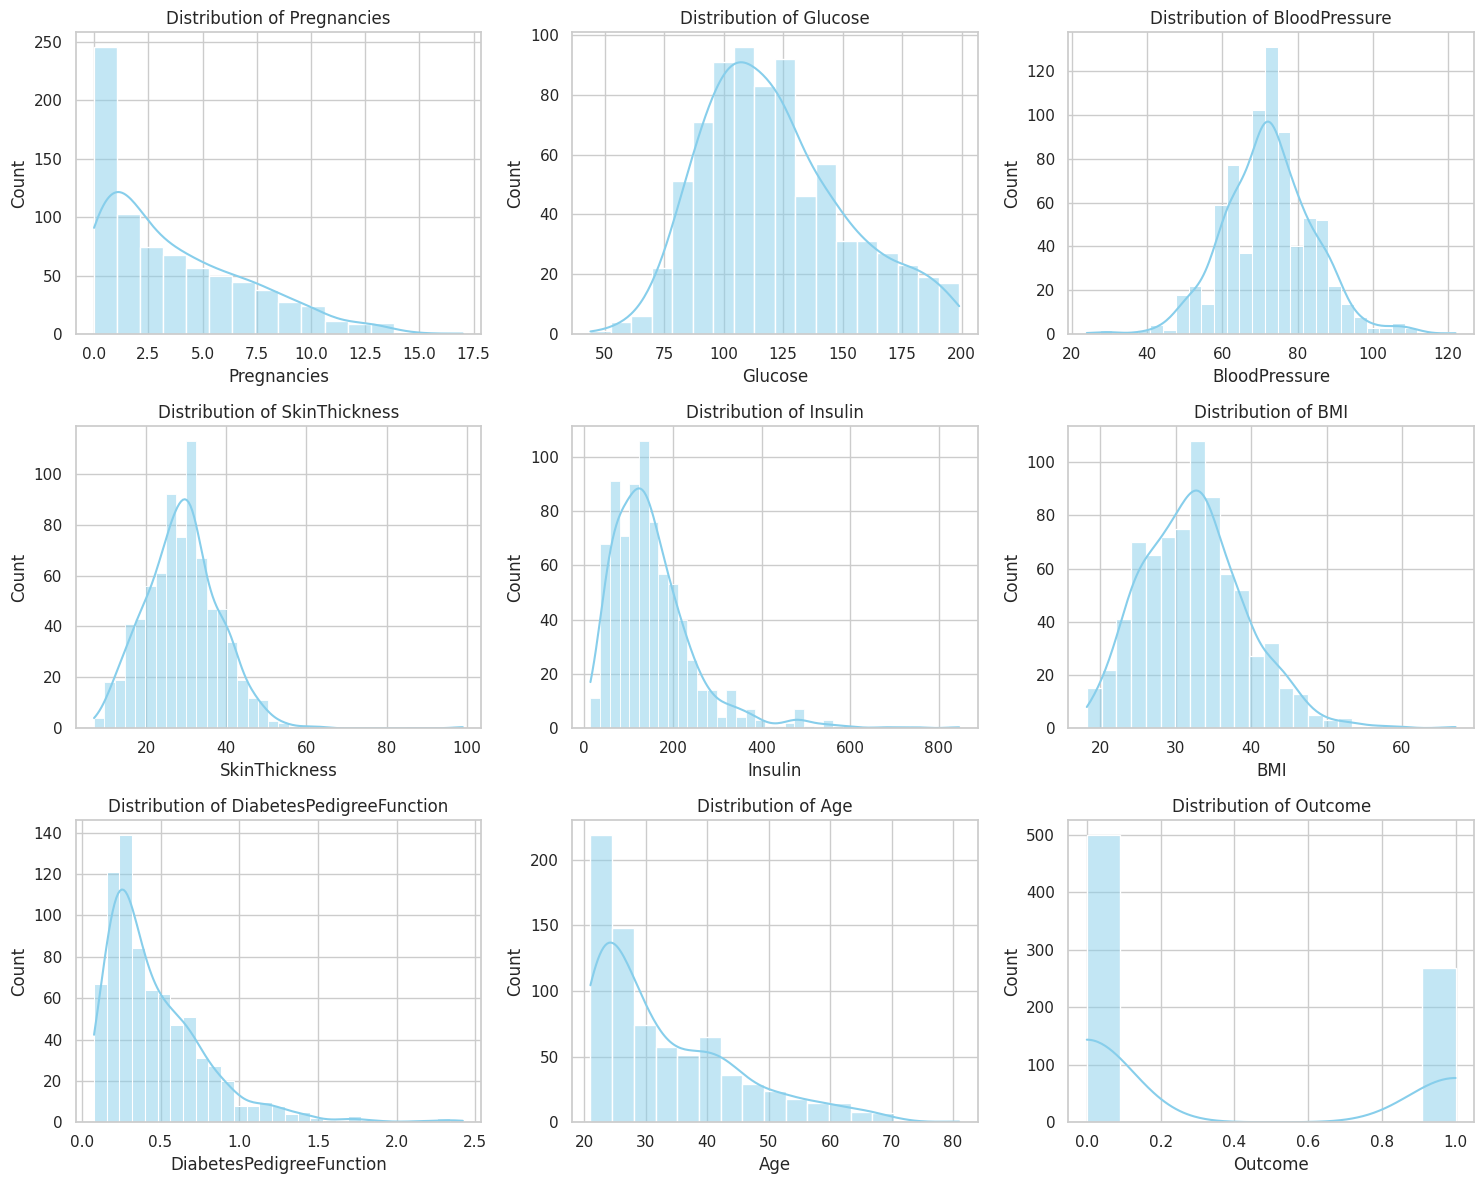

In [14]:
# 1️⃣ Histogram for all features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
plt.tight_layout()
plt.show()

* Pregnancies, DiabetesPedigreeFunction, and Age are right-skewed.
* Insulin has a huge spike near zero and a long tail — lots of extreme values.
* Outcome confirms our earlier point: class imbalance (more negatives than positives).

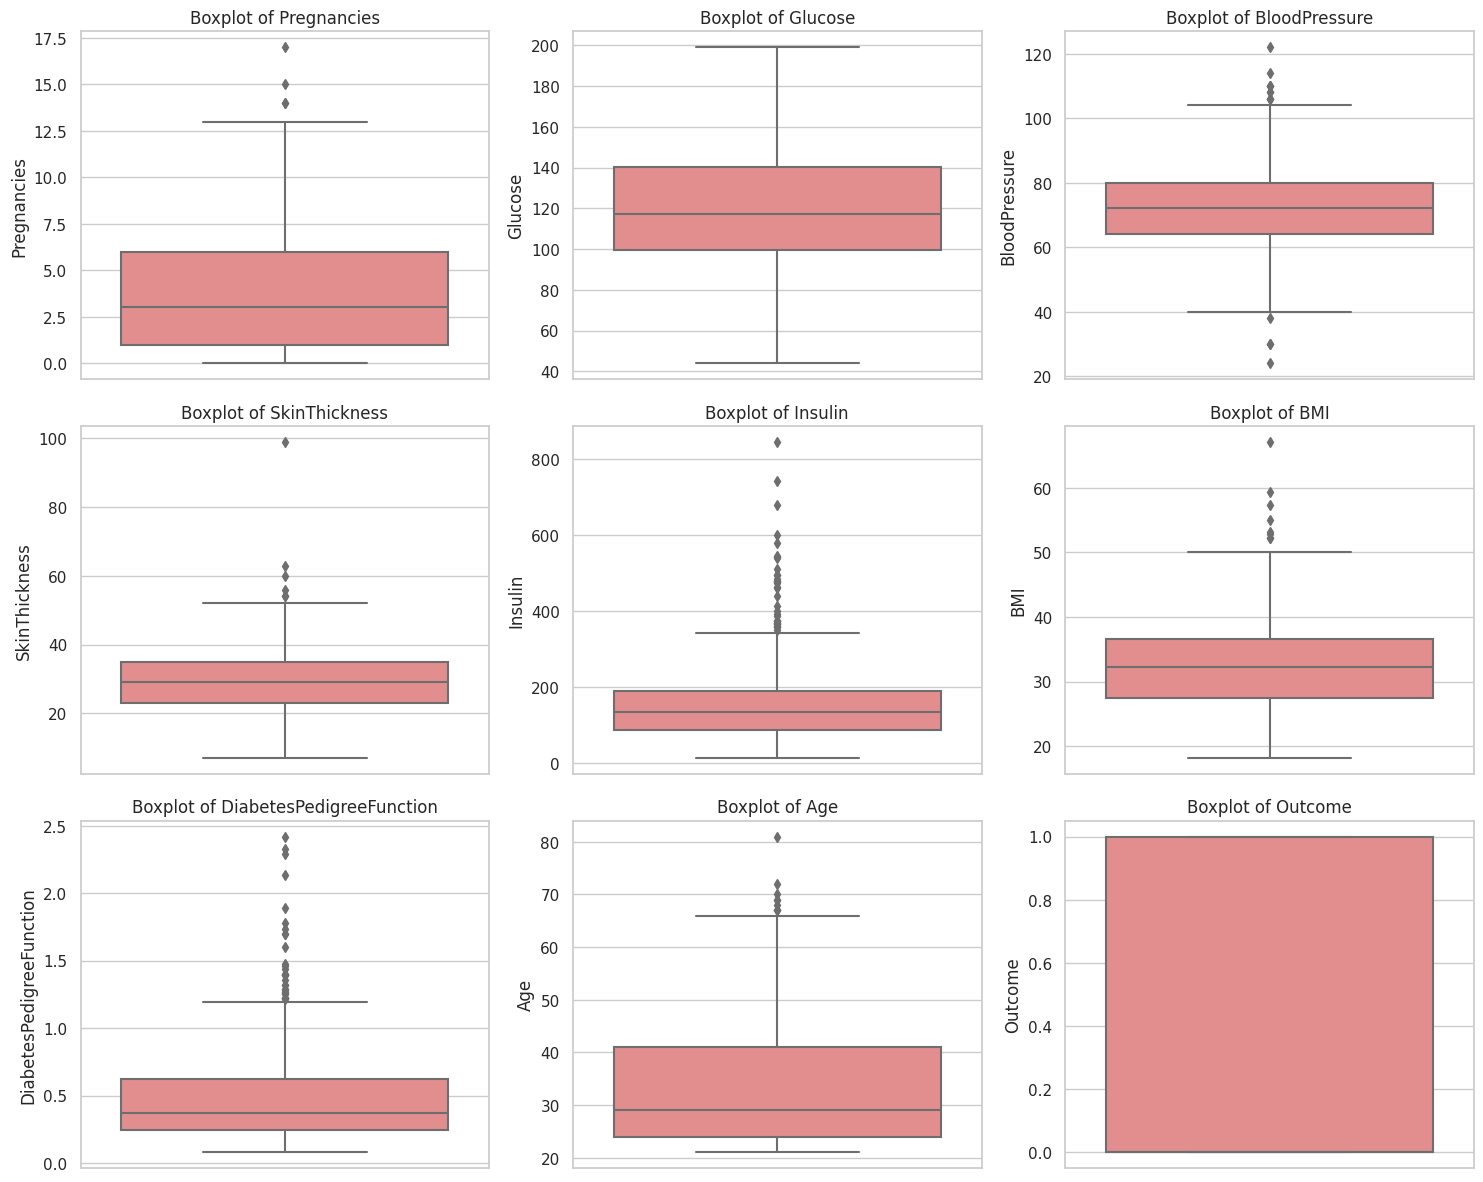

In [15]:
# 2️⃣ Boxplots for all features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot of {col}', fontsize=12)
plt.tight_layout()
plt.show()

* Clear outliers in Pregnancies, BloodPressure (low outliers too), SkinThickness, Insulin, BMI, and DiabetesPedigreeFunction.
* Insulin has the heaviest extreme outliers — some >800, which are biologically unusual.
* Outcome boxplot is flat because it’s binary.

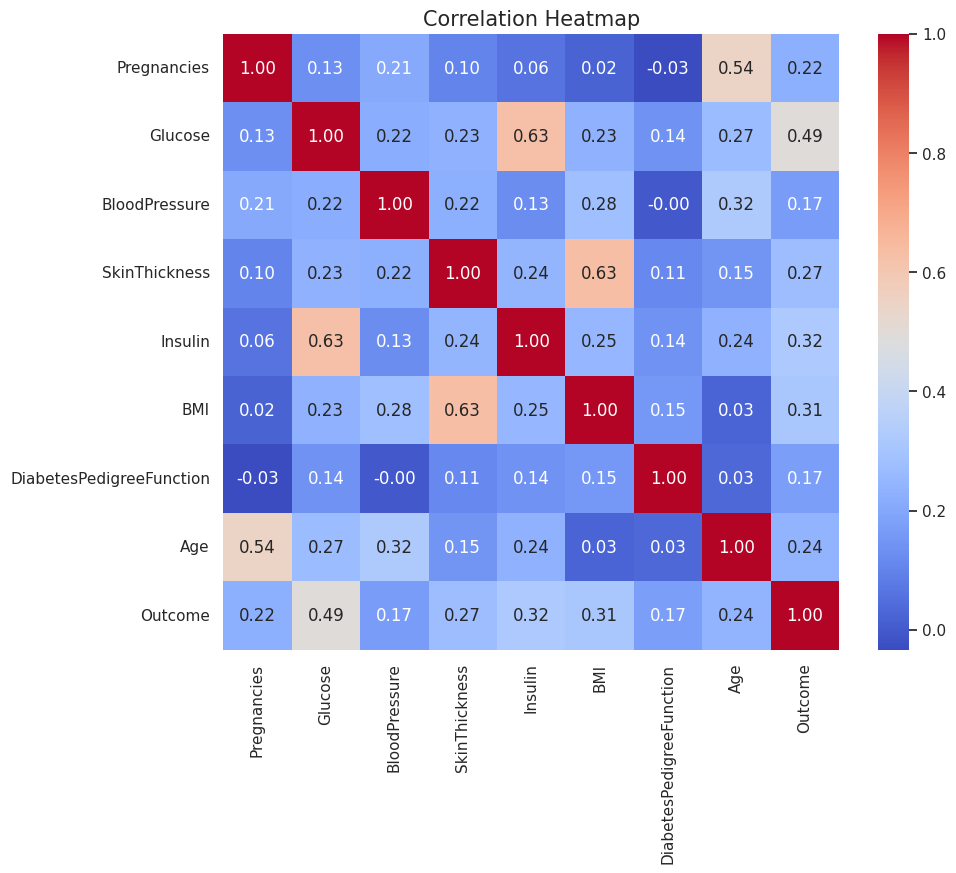

In [16]:
# 3️⃣ Correlation heatmap
plt.figure(figsize=(10, 8))
corr = pd.DataFrame(df, columns=df.columns).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap", fontsize=15)
plt.show()

* Glucose is most correlated with Outcome (0.49), followed by BMI (0.31), Age (0.24), and Pregnancies (0.22).
* Insulin and SkinThickness are moderately correlated (0.63).
* Most other relationships are weak — no dangerous multicollinearity.

# outlier detection

In [17]:
import pandas as pd
import numpy as np

# Copy to preserve original
df_check = df.copy()

# Store outlier stats
outlier_summary = []

# DataFrame to track outlier flags
outlier_flags = pd.DataFrame(False, index=df_check.index, columns=df_check.columns)

for col in df_check.select_dtypes(include=[np.number]).columns:
    if col != 'Outcome':  # skip binary target
        Q1 = df_check[col].quantile(0.25)
        Q3 = df_check[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        mask = (df_check[col] < lower) | (df_check[col] > upper)
        outlier_flags[col] = mask
        
        outlier_summary.append({
            'Feature': col,
            'Outlier Count': mask.sum(),
            'Outlier %': round(mask.sum() / len(df_check) * 100, 2)
        })

In [18]:
# Summary table
outlier_summary_df = pd.DataFrame(outlier_summary).sort_values(by='Outlier %', ascending=False)

# Rows containing any outlier
outlier_rows = df_check[outlier_flags.any(axis=1)]

# Show results
print("Outlier Summary Table:")
print(outlier_summary_df)

print(f"Rows with any outliers: {len(outlier_rows)}")
display(outlier_rows)

Outlier Summary Table:
                    Feature  Outlier Count  Outlier %
4                   Insulin             34       4.43
6  DiabetesPedigreeFunction             29       3.78
2             BloodPressure             14       1.82
7                       Age              9       1.17
5                       BMI              8       1.04
3             SkinThickness              6       0.78
0               Pregnancies              4       0.52
1                   Glucose              0       0.00
Rows with any outliers: 94


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
12,10,139.0,80.0,22.6,204.0,27.1,1.441,57,0
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
18,1,103.0,30.0,38.0,83.0,43.3,0.183,33,0
...,...,...,...,...,...,...,...,...,...
691,13,158.0,114.0,36.4,215.6,42.3,0.257,44,1
695,7,142.0,90.0,24.0,480.0,30.4,0.128,43,1
710,3,158.0,64.0,13.0,387.0,31.2,0.295,24,0
715,7,187.0,50.0,33.0,392.0,33.9,0.826,34,1


* Insulin is clearly the biggest “wild child” here → ~4.43% of the dataset (34 rows) flagged.
* DiabetesPedigreeFunction comes next, then BloodPressure.
* Glucose has zero detected outliers using Tukey’s 1.5×IQR rule (which is interesting given your EDA hinting at high correlation with Outcome).
* 94 total rows with at least one outlier.